In [30]:
%pip install tabulate


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime, sys, sklearn

ROOT_DIR = Path(__file__).resolve().parents[1] if "__file__" in locals() else Path.cwd().parents[0]
TRAIN_PATH = ROOT_DIR / "data" / "splits" / "train.csv"
VAL_PATH = ROOT_DIR / "data" / "splits" / "val.csv"
TEST_PATH = ROOT_DIR / "data" / "splits" / "test.csv"
OUT_DIR = ROOT_DIR / "data" / "cleaned"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [32]:
train = pd.read_csv(TRAIN_PATH)
val = pd.read_csv(VAL_PATH)
test = pd.read_csv(TEST_PATH)

df = pd.concat([train, val, test], keys=["train","val","test"])
df.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
train 0    Male              0     Yes         No      62          Yes   
      1  Female              0     Yes        Yes      60           No   
      2    Male              0      No         No      53          Yes   
      3  Female              1     Yes         No      43           No   
      4  Female              0      No         No      72          Yes   

            MultipleLines InternetService OnlineSecurity OnlineBackup  \
train 0                No             DSL             No          Yes   
      1  No phone service             DSL             No          Yes   
      2                No             DSL             No           No   
      3  No phone service             DSL             No          Yes   
      4                No             DSL            Yes          Yes   

        DeviceProtection TechSupport StreamingTV StreamingMovies  \
train 0              Yes         Yes          No              No   
      1               No          No         Yes             Yes   
      2              Yes          No          No             Yes   
      3              Yes          No         Yes             Yes   
      4              Yes         Yes          No             Yes   

               Contract PaperlessBilling            PaymentMethod  \
train 0        Two year              Yes  Credit card (automatic)   
      1  Month-to-month              Yes         Electronic check   
      2        One year              Yes         Electronic check   
      3  Month-to-month               No  Credit card (automatic)   
      4        Two year              Yes  Credit card (automatic)   

         MonthlyCharges TotalCharges  Churn  
train 0           60.15       3753.2      0  
      1           49.75      3069.45      0  
      2           61.10       3357.9      0  
      3           55.55       2342.2      1  
      4           73.00       5265.2      0

In [33]:
missing = df.isnull().sum()
missing

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [34]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan).astype(float)
mask = df["tenure"] == 0
df.loc[mask, "TotalCharges"] = df.loc[mask, "TotalCharges"].fillna(0)

In [35]:
df["SeniorCitizen"] = df["SeniorCitizen"].astype(int)

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical:", cat_cols)
print("Numerical:", num_cols)

Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']


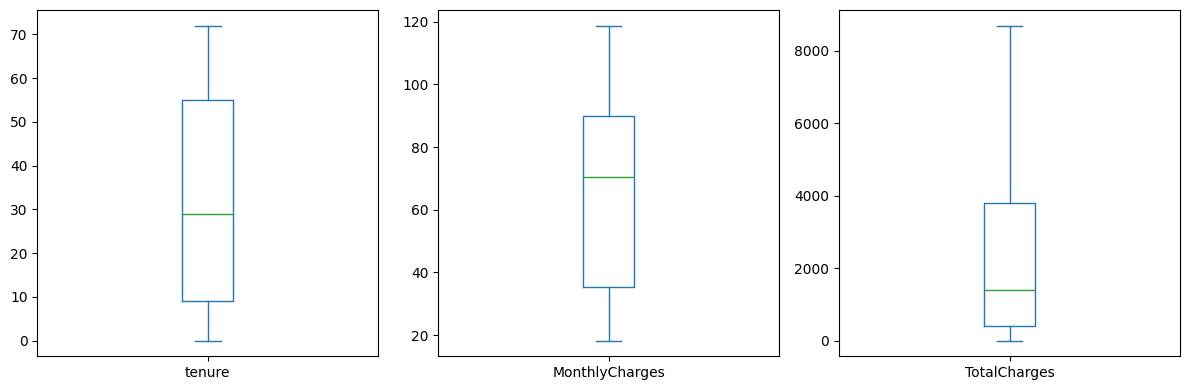

In [36]:
import matplotlib.pyplot as plt

num_cols = ["tenure","MonthlyCharges","TotalCharges"]
df[num_cols].plot(kind="box", subplots=True, layout=(1,3), figsize=(12,4))
plt.tight_layout()
plt.show()

In [37]:
issues = {
    "negative_tenure": (df["tenure"] < 0).sum(),
    "negative_charges": (df["MonthlyCharges"] < 0).sum() + (df["TotalCharges"] < 0).sum(),
    "special_chars": df.select_dtypes("object").apply(lambda x: x.str.contains(r"[^a-zA-Z0-9\s\.\-]", na=False).sum()).sum()
}
issues

{'negative_tenure': np.int64(0),
 'negative_charges': np.int64(0),
 'special_chars': np.int64(3066)}

In [38]:
df.loc["train"].to_csv(OUT_DIR / "train_clean.csv", index=False)
df.loc["val"].to_csv(OUT_DIR / "val_clean.csv", index=False)
df.loc["test"].to_csv(OUT_DIR / "test_clean.csv", index=False)

In [39]:
(REPORT_DIR := ROOT_DIR / "reports").mkdir(parents=True, exist_ok=True)
Path(REPORT_DIR / "data_cleaning_report.md").write_text(md, encoding="utf-8")

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

md = f"""# Data Cleaning Report

**Datum/Zeit:** {now}  
**random_state:** 42  

---

## 🧹 Overview
- Missing values handled (TotalCharges = 0 where tenure = 0)
- Data types standardized:
  - SeniorCitizen → int (0/1)
  - All other categorical fields → string
- Outliers checked (Boxplot of tenure, MonthlyCharges, TotalCharges)
- Consistency verified: no negative or non-numeric values

---

## 🔍 Missing Values (before cleaning)
{missing.to_markdown()}
---

## ✅ Consistency Checks
| Check | Count |
|--------|-------:|
| Negative tenure | {issues['negative_tenure']} |
| Negative charges | {issues['negative_charges']} |
| Special characters | {issues['special_chars']} |

---

## 📂 Output
- data/cleaned/train_clean.csv  
- data/cleaned/val_clean.csv  
- data/cleaned/test_clean.csv  

---

## 🧠 Note
All transformations follow reproducibility guidelines according to **CRISP-ML(Q)** (Studer et al., 2021).
"""

Path(ROOT_DIR / "reports" / "data_cleaning_report.md").write_text(md, encoding="utf-8")

1412